<a href="https://colab.research.google.com/github/GeraldL19/loan_default_prediction/blob/main/Spot_Testing_Model_SMOTE_Hyper__03_01_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The metrics used to determined the accuracy of the model are:

**Precition** : is the positive observations (true positives) the model correctly identified from all the observations it labeled as positive (the true positives + the false positives).

**Recall** : s the positive observations (true positives) the model correctly identified from all the actual positive cases (the true positives + the false negatives).

**F2 score** : The F2 score is the weighted harmonic mean of the precision and recall (given a threshold value). Unlike the F1 score, which gives equal weight to precision and recall, the F2 score gives more weight to recall than to precision.

Formula : F2=5((precision)(recall)((4)(precision))+recall)

(https://docs.h2o.ai/driverless-ai/1-10-lts/docs/userguide/scorers.html#:~:text=The%20F2%20score%20is%20the,to%20recall%20than%20to%20precision.)


In [36]:
#!pip install --pre pycaret

In [115]:
# Installed packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
import pycaret.classification as pyc
from pycaret.classification import *

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [116]:
#Import clean dataset from GoogleDrive
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clean_data.csv", index_col=0)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,24.0,49000.0,RENT,8.0,DEBTCONSOLIDATION,D,4400.0,16.770000,0.09,Y,3.0,1
1,39.0,91992.0,MORTGAGE,0.0,HOMEIMPROVEMENT,A,3350.0,5.420000,0.04,N,11.0,0
2,29.0,55000.0,MORTGAGE,11.0,PERSONAL,B,4000.0,10.990000,0.07,N,8.0,0
3,23.0,48600.0,MORTGAGE,7.0,PERSONAL,B,19000.0,11.360000,0.39,N,4.0,0
4,22.0,50000.0,OWN,4.0,VENTURE,B,16000.0,9.450000,0.32,N,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32403,23.0,55000.0,MORTGAGE,7.0,MEDICAL,A,8000.0,7.490000,0.15,N,4.0,0
32404,22.0,54800.0,OWN,7.0,EDUCATION,A,8000.0,6.697063,0.15,N,2.0,0
32405,34.0,87360.0,MORTGAGE,11.0,PERSONAL,B,12000.0,11.110000,0.14,N,5.0,0
32406,38.0,61000.0,RENT,0.0,EDUCATION,B,1000.0,9.450000,0.02,N,12.0,0


In [118]:
# Create an object of class OrdinalEncoder
ordinalencoder = OrdinalEncoder()
# Specify the columns to be encoded
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# Fit and transform the desired categorical columns
df[columns_to_encode] = ordinalencoder.fit_transform(df[columns_to_encode])

In [119]:
cols_to_norm = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

In [41]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [42]:
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle=True)

# Basic PyCaret spot check of best performing algorythms

Using Pycaret as a simple, fast and low code method for spot checking for the best performing algorythms.

In [43]:
# Setting pycaret
model = setup(data = df, target = 'loan_status', session_id=123)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(32408, 12)"
4,Transformed data shape,"(32408, 12)"
5,Transformed train set shape,"(22685, 12)"
6,Transformed test set shape,"(9723, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [44]:
# Comparing algorythms
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9357,0.9459,0.7251,0.9746,0.8314,0.7927,0.8061,2.8460
xgboost,Extreme Gradient Boosting,0.9348,0.9445,0.7375,0.9537,0.8317,0.7921,0.8022,0.4130
rf,Random Forest Classifier,0.9295,0.9286,0.7043,0.9637,0.8137,0.7716,0.7861,2.6430
gbc,Gradient Boosting Classifier,0.9234,0.9258,0.6936,0.9407,0.7984,0.7525,0.7659,2.6230
et,Extra Trees Classifier,0.9223,0.9198,0.6926,0.9357,0.7959,0.7492,0.7622,1.7740
ada,Ada Boost Classifier,0.8886,0.8990,0.6603,0.7957,0.7217,0.6529,0.6573,0.7500
knn,K Neighbors Classifier,0.8864,0.8570,0.6051,0.8297,0.6997,0.6318,0.6439,0.6980
dt,Decision Tree Classifier,0.8845,0.8391,0.7583,0.7261,0.7418,0.6674,0.6678,0.1180
lr,Logistic Regression,0.8454,0.8498,0.4668,0.7297,0.5690,0.4804,0.4984,0.6800
lda,Linear Discriminant Analysis,0.8423,0.8487,0.4838,0.7032,0.5729,0.4803,0.4931,0.1170


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [45]:
# Evaluating Algorythms
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
F2 = (5 * 0.9746 * 0.7196) / (4 * 0.9746 + 0.7196)
F2

0.7593353832828064

*   We can clearly see that the class imbalance is creating a bias towards the majority class. the recall is prety low at around 72% at the highest. This means that few of the smaller class prediction a accurate. This is the accuracy paradox
*   We will explore multiple solution in order to fix this issue.

This first simlpe spot check show us that the top 3 performing algorithms for this task might be:


*   lightgbm	- Light Gradient Boosting Machine
*   xgboost	- Extreme Gradient Boosting
*   rf	- Random Forest Classifier

The base F2 score to start with (from the lightgbm) is 76%.

# PyCaret with Smote

We try to apply the SMOTE technique with PyCaret to see if we can improve the prediction for the minority class ('default').

In [47]:
from imblearn.combine import *
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting up the SMOTE function
over_sampling = SMOTE(sampling_strategy=0.5)

# Applying to dataset
X_smote, y_smote = over_sampling.fit_resample(X, y)

# Create a DataFrame with the SMOTE-transformed features and target
df_smote = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.Series(y_smote, name='target')], axis=1)

In [48]:
df_smote

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,target
0,0.205063,1.506253,0,-1.191192,5,1,2.437550,-0.288992,-0.002294,0,0.539782,0
1,-0.278845,0.440282,0,0.555088,1,2,-0.600010,0.297758,-0.938768,1,-0.939438,0
2,-0.117543,0.725559,3,0.804557,2,0,0.507434,-1.155147,-0.470531,0,-0.199828,0
3,0.205063,-0.188425,3,-1.191192,4,1,-1.011347,-0.050788,-1.032416,0,0.293245,0
4,-0.762753,0.458980,3,-1.191192,0,2,-0.251956,0.726179,-0.751474,1,-0.692901,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37975,-0.924056,-0.166051,3,0.305620,1,5,1.013694,1.905888,1.027827,0,-0.499340,1
37976,-0.582474,0.181268,0,0.555088,0,3,2.418938,1.398287,1.523607,1,-0.721906,1
37977,5.680439,0.037773,3,-1.073351,1,3,1.160765,1.707995,0.641471,1,5.717053,1
37978,-0.924056,-0.510968,3,-0.389874,5,3,-0.477273,1.423472,-0.002294,1,-0.692901,1


In [49]:
# Setup PyCaret with the SMOTE-transformed dataset
exp = setup(data=df_smote, target='target', session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(37980, 12)"
4,Transformed data shape,"(37980, 12)"
5,Transformed train set shape,"(26586, 12)"
6,Transformed test set shape,"(11394, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [50]:
# Compare models and select the best one
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9361,0.9684,0.8351,0.9689,0.8970,0.8511,0.8560,0.2940
lightgbm,Light Gradient Boosting Machine,0.9336,0.9662,0.8173,0.9802,0.8913,0.8440,0.8513,2.7120
et,Extra Trees Classifier,0.9220,0.9613,0.8108,0.9477,0.8738,0.8179,0.8231,2.0910
rf,Random Forest Classifier,0.9194,0.9611,0.7865,0.9654,0.8668,0.8099,0.8187,3.4520
gbc,Gradient Boosting Classifier,0.8964,0.9404,0.7475,0.9279,0.8279,0.7551,0.7641,3.5310
dt,Decision Tree Classifier,0.8754,0.8609,0.8173,0.8106,0.8139,0.7203,0.7204,0.1390
knn,K Neighbors Classifier,0.8650,0.9188,0.7811,0.8078,0.7941,0.6937,0.6941,0.5880
ada,Ada Boost Classifier,0.8645,0.9093,0.7398,0.8349,0.7844,0.6862,0.6889,1.0270
lr,Logistic Regression,0.8004,0.8488,0.6174,0.7407,0.6733,0.5313,0.5360,0.0880
lda,Linear Discriminant Analysis,0.7998,0.8484,0.6117,0.7425,0.6706,0.5288,0.5340,0.0860


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

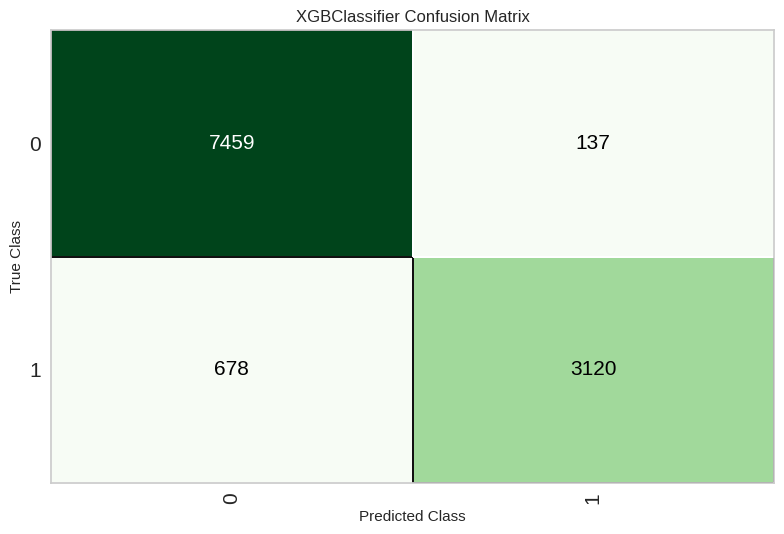

In [51]:
# Evaluate the best model
evaluate_model(best_model)

In [89]:
F2 = (5 * 0.9689 * 0.8351) / (4 * 0.9689 + 0.8351)
F2

0.8588196977094698

We can observe some improvement after using SMOTE. The F2 score is now 86% and recall as hight as 83%.

# PyCaret with Smote and Tomek Links

We now try a slightly different method.

Over-sampling using SMOTE and cleaning using Tomek links.

Combine over- and under-sampling using SMOTE and Tomek links.

In [53]:
from imblearn.combine import *
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Setting up the SMOTETomek function
smt = SMOTETomek(random_state=42)

# Applying to the dataset
X_smotek, y_smotek = smt.fit_resample(X, y)

# Create a DataFrame with the SMOTE-transformed features and target
df_smtek = pd.concat([pd.DataFrame(X_smotek, columns=X.columns), pd.Series(y_smotek, name='target')], axis=1)

In [54]:
# Setup PyCaret with the SMOTE-transformed dataset
exp = setup(data=df_smtek, target='target', session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(50110, 12)"
4,Transformed data shape,"(50110, 12)"
5,Transformed train set shape,"(35077, 12)"
6,Transformed test set shape,"(15033, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [55]:
# Compare models and select the best one
best_tek = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9517,0.9851,0.9194,0.9829,0.9501,0.9034,0.9053,0.6590
lightgbm,Light Gradient Boosting Machine,0.9501,0.9834,0.9120,0.9872,0.9481,0.9002,0.9028,4.7680
et,Extra Trees Classifier,0.9384,0.9840,0.9191,0.9560,0.9372,0.8768,0.8775,2.6420
rf,Random Forest Classifier,0.9339,0.9828,0.8959,0.9696,0.9313,0.8678,0.8703,4.9760
gbc,Gradient Boosting Classifier,0.8922,0.9587,0.8435,0.9345,0.8866,0.7844,0.7882,5.7440
dt,Decision Tree Classifier,0.8809,0.8809,0.8872,0.8762,0.8816,0.7617,0.7618,0.1940
knn,K Neighbors Classifier,0.8687,0.9456,0.9174,0.8360,0.8748,0.7373,0.7409,1.1130
ada,Ada Boost Classifier,0.8569,0.9269,0.8360,0.8726,0.8538,0.7138,0.7145,1.5550
lr,Logistic Regression,0.7801,0.8528,0.7796,0.7805,0.7800,0.5602,0.5603,0.1090
ridge,Ridge Classifier,0.7792,0.0000,0.7737,0.7825,0.7780,0.5585,0.5586,0.0490


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

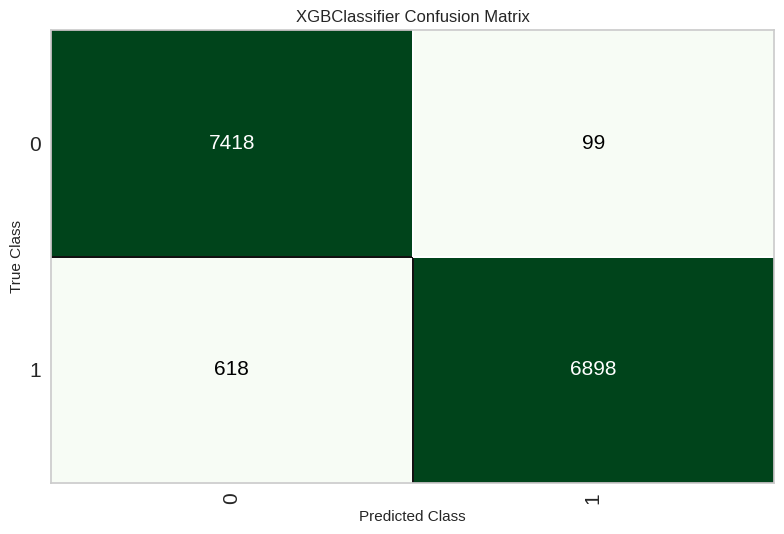

In [56]:
# Evaluate the best model
evaluate_model(best_tek)

In [90]:
F2 = (5 * 0.9829 * 0.9194) / (4 * 0.9829 + 0.9194)
F2

0.9314350237064524

This is even better. The F2 score is now 93% with a recall up to 92%.

# PyCaret lightGBM with Smote and Tomek - hyper param tuning - **NOT WORKING**

We take the best performing algorythm so far (lightGBM) and the best over/under sampling method and use the automatic hyperparameter tuning to optimixe the model and the accuracy.

In [94]:
from imblearn.combine import *
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Setting up SmoteTomek
smt = SMOTETomek(random_state=42)

# Applying it to the dataset
X_smotek, y_smotek = smt.fit_resample(X, y)

# Create a DataFrame with the SMOTE-transformed features and target
df_smtek = pd.concat([pd.DataFrame(X_smotek, columns=X.columns), pd.Series(y_smotek, name='target')], axis=1)

In [95]:
# Setup PyCaret with the SMOTE-transformed dataset
exp = setup(data=df_smtek, target='target', session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(50110, 12)"
4,Transformed data shape,"(50110, 12)"
5,Transformed train set shape,"(35077, 12)"
6,Transformed test set shape,"(15033, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [96]:
# train model
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9561,0.9850,0.9173,0.9944,0.9543,0.9122,0.9150
1,0.9590,0.9854,0.9322,0.9849,0.9578,0.9179,0.9192
2,0.9524,0.9861,0.9139,0.9901,0.9505,0.9048,0.9075
3,0.9464,0.9812,0.9088,0.9827,0.9443,0.8928,0.8954
4,0.9507,0.9832,0.9105,0.9901,0.9486,0.9014,0.9043
5,0.9467,0.9844,0.9082,0.9839,0.9446,0.8934,0.8960
6,0.9495,0.9847,0.9094,0.9888,0.9474,0.8991,0.9020
7,0.9478,0.9827,0.9111,0.9834,0.9458,0.8956,0.8981
8,0.9510,0.9812,0.9122,0.9889,0.9490,0.9019,0.9046


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [97]:
tuned_lgbm = tune_model(lgbm, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5000,0.9294,1.0000,0.5000,0.6667,0.0000,0.0000
1,0.5000,0.9388,1.0000,0.5000,0.6667,0.0000,0.0000
2,0.5000,0.9380,1.0000,0.5000,0.6667,0.0000,0.0000
3,0.5000,0.9286,1.0000,0.5000,0.6667,0.0000,0.0000
4,0.5000,0.9379,1.0000,0.5000,0.6667,0.0000,0.0000
5,0.5000,0.9336,1.0000,0.5000,0.6667,0.0000,0.0000
6,0.5000,0.9371,1.0000,0.5000,0.6667,0.0000,0.0000
7,0.8677,0.9360,0.7856,0.9400,0.8559,0.7354,0.7455
8,0.8731,0.9371,0.8016,0.9355,0.8634,0.7462,0.7540


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [62]:
# Evaluate the best model
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [63]:
print(tuned_lgbm)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=6, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=66, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=90, n_jobs=-1, num_leaves=90, objective=None,
               random_state=123, reg_alpha=0.0005, reg_lambda=0.1,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


# PyCaret with Smote and Under Sampling

Trying the SMOTE + Under sampling method with PyCaret.

In [64]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [65]:
# Define SMOTE and Undersampling techniques
oversample = SMOTE()
undersample = RandomUnderSampler()

# Create a pipeline
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)

# Initialize PyCaret
exp = setup(df, target='loan_status', session_id=123, preprocess=pipeline)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(32408, 12)"
4,Transformed data shape,"(32408, 12)"
5,Transformed train set shape,"(22685, 12)"
6,Transformed test set shape,"(9723, 12)"
7,Numeric features,11
8,Preprocess,"Pipeline(memory=None, steps=[('o', SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto')), ('u', RandomUnderSampler(random_state=None, replacement=False, sampling_strategy='auto'))], verbose=False)"
9,Imputation type,simple


In [66]:
# Create a model using PyCaret
smunder = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9357,0.9459,0.7251,0.9746,0.8314,0.7927,0.8061,3.9600
xgboost,Extreme Gradient Boosting,0.9348,0.9445,0.7375,0.9537,0.8317,0.7921,0.8022,0.4020
rf,Random Forest Classifier,0.9295,0.9286,0.7043,0.9637,0.8137,0.7716,0.7861,2.6110
gbc,Gradient Boosting Classifier,0.9234,0.9258,0.6936,0.9407,0.7984,0.7525,0.7659,2.3690
et,Extra Trees Classifier,0.9223,0.9198,0.6926,0.9357,0.7959,0.7492,0.7622,1.7930
ada,Ada Boost Classifier,0.8886,0.8990,0.6603,0.7957,0.7217,0.6529,0.6573,0.7810
knn,K Neighbors Classifier,0.8864,0.8570,0.6051,0.8297,0.6997,0.6318,0.6439,0.7250
dt,Decision Tree Classifier,0.8845,0.8391,0.7583,0.7261,0.7418,0.6674,0.6678,0.1160
lr,Logistic Regression,0.8454,0.8498,0.4668,0.7297,0.5690,0.4804,0.4984,0.1170
lda,Linear Discriminant Analysis,0.8423,0.8487,0.4838,0.7032,0.5729,0.4803,0.4931,0.0760


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [67]:
# Evaluate the best model
evaluate_model(smunder)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [68]:
F2 = (5 * 0.9746 * 0.7196) / (4 * 0.9746 + 0.7196)
F2

0.7593353832828064

This is not a good method for our dataset.

# RF Weighted

Trying a cost sensitive mtehod for dealing with the accuracy paradox - **Weighted Random Forest**

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define your misclassification costs or use 'balanced' to automatically assign weights
class_weights = 'balanced'  # Adjust the weights based on your specific costs

# Create a Random Forest classifier with cost-sensitive learning
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      7557
           1       0.97      0.69      0.81      2166

    accuracy                           0.93      9723
   macro avg       0.95      0.84      0.88      9723
weighted avg       0.93      0.93      0.92      9723



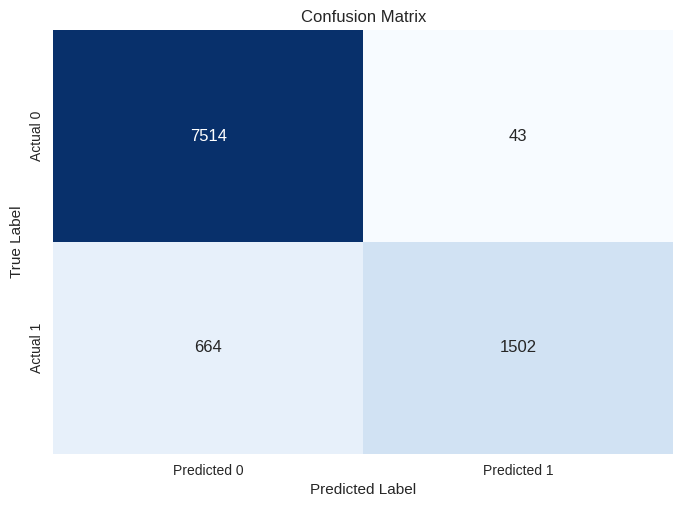

In [70]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [71]:
F2 = (5 * 0.93 * 0.93) / (4 * 0.93 + 0.93)
F2

0.93

This is a good outcome with F2 = 93%.

#Decision Trees Weighted

In [72]:
from sklearn.tree import DecisionTreeClassifier

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your misclassification costs or use 'balanced' to automatically assign weights
class_weights = 'balanced'  # Adjust the weights based on your specific costs

# Create a Decision Tree classifier with cost-sensitive learning
dt_classifier = DecisionTreeClassifier(class_weight=class_weights, random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5043
           1       0.76      0.75      0.76      1439

    accuracy                           0.89      6482
   macro avg       0.85      0.84      0.84      6482
weighted avg       0.89      0.89      0.89      6482



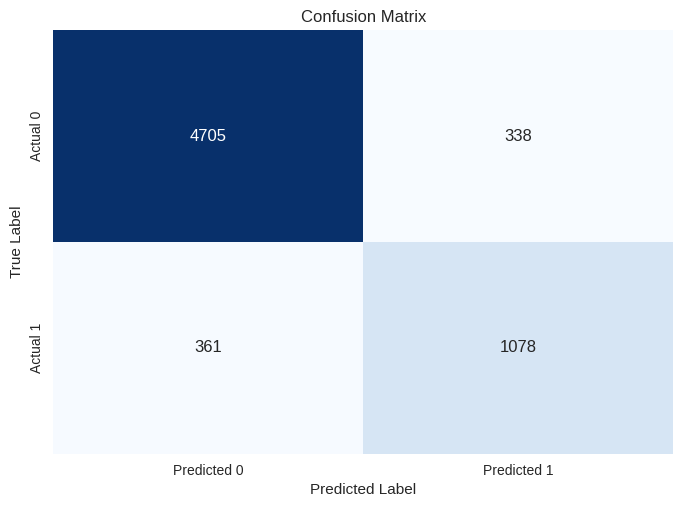

In [73]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Not as good.

#SKLearn Basic Spot Check Algorithms

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, f1_score

from imblearn.combine import *
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [75]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f'Accuracy for {model_name}: {accuracy}')
    print(f'Recall for {model_name}: {recall}\n')

Training and evaluating Random Forest...
Accuracy for Random Forest: 0.9282114573691248
Recall for Random Forest: 0.698522622345337

Training and evaluating Decision Tree...
Accuracy for Decision Tree: 0.8902602077548082
Recall for Decision Tree: 0.7506925207756233

Training and evaluating SVM...
Accuracy for SVM: 0.8835750282834516
Recall for SVM: 0.574792243767313

Training and evaluating XGBoost...
Accuracy for XGBoost: 0.9333539031163222
Recall for XGBoost: 0.7405355493998154

Training and evaluating Gradient Boosting...
Accuracy for Gradient Boosting: 0.9189550550241695
Recall for Gradient Boosting: 0.6869806094182825

Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 4922, number of negative: 17763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[L

Imbalance

CGBoost
LightGBM
Random Forest

# SKLearn with Smote

Applying SMOTE oversampling with SKLearn.

In [76]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTE
over_sampling = SMOTE()

#Applying smote to training set
X_smote, y_smote = over_sampling.fit_resample(X, y)

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# List of models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Train the model
    model.fit(X_train_smote, y_train_smote)

    # Make predictions on the test set
    y_pred_smote = model.predict(X_test_smote)

    # Evaluate the model
    accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)
    recall_smote = recall_score(y_test_smote, y_pred_smote)
    f1_smote = f1_score(y_test_smote, y_pred_smote)
    f2_smote = fbeta_score(y_test_smote, y_pred_smote, beta=2)

    print(f'Accuracy for {model_name}: {accuracy_smote}')
    print(f'Recall for {model_name}: {recall_smote}')
    print(f'F1 Score for {model_name}: {f1_smote}')
    print(f'F2 Score for {model_name}: {f2_smote}\n')

Training and evaluating Random Forest...
Accuracy for Random Forest: 0.9353607161664034
Recall for Random Forest: 0.8979347101932045
F1 Score for Random Forest: 0.932088520055325
F2 Score for Random Forest: 0.9112914131169707

Training and evaluating Decision Tree...
Accuracy for Decision Tree: 0.8803317535545023
Recall for Decision Tree: 0.8910059960026648
F1 Score for Decision Tree: 0.8803317535545023
F2 Score for Decision Tree: 0.8867053862678018

Training and evaluating SVM...
Accuracy for SVM: 0.8238546603475514
Recall for SVM: 0.7741505662891406
F1 Score for SVM: 0.8128147733631785
F2 Score for SVM: 0.7891662818179348

Training and evaluating XGBoost...
Accuracy for XGBoost: 0.95115850447604
Recall for XGBoost: 0.9157894736842105
F1 Score for XGBoost: 0.9487852015461071
F2 Score for XGBoost: 0.9287084830959652

Training and evaluating Gradient Boosting...
Accuracy for Gradient Boosting: 0.8869799894681412
Recall for Gradient Boosting: 0.8397068620919387
F1 Score for Gradient Boos

# SKLearn with Smote and Tomek

In [77]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTETomek
smt = SMOTETomek(random_state=42)

#Applying smotetomek to training set
X_smote_tek, y_smote_tek = smt.fit_resample(X, y)

# Split the data into training and testing sets
X_train_tek, X_test_tek, y_train_tek, y_test_tek = train_test_split(X_smote_tek, y_smote_tek, test_size=0.3, random_state=42)

# List of models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")

    # Train the model
    model.fit(X_train_tek, y_train_tek)

    # Make predictions on the test set
    y_pred_tek = model.predict(X_test_tek)

    # Evaluate the model
    accuracy_tek= accuracy_score(y_test_tek, y_pred_tek)
    recall_tek = recall_score(y_test_tek, y_pred_tek)
    f1_tek = f1_score(y_test_tek, y_pred_tek)
    f2_tek = fbeta_score(y_test_tek, y_pred_tek, beta=2)

    print(f'Accuracy for {model_name}: {accuracy_tek}')
    print(f'Recall for {model_name}: {recall_tek}')
    print(f'F1 Score for {model_name}: {f1_tek}')
    print(f'F2 Score for {model_name}: {f2_tek}\n')

Training and evaluating Random Forest...
Accuracy for Random Forest: 0.9320827512805162
Recall for Random Forest: 0.889827100924809
F1 Score for Random Forest: 0.9285964053430309
F2 Score for Random Forest: 0.90493975246715

Training and evaluating Decision Tree...
Accuracy for Decision Tree: 0.8795982172553715
Recall for Decision Tree: 0.8832596166733682
F1 Score for Decision Tree: 0.8792528352234823
F2 Score for Decision Tree: 0.8816525299012657

Training and evaluating SVM...
Accuracy for SVM: 0.8265815206545599
Recall for SVM: 0.7734888084707143
F1 Score for SVM: 0.8157466958795673
F2 Score for SVM: 0.7898554691777072

Training and evaluating XGBoost...
Accuracy for XGBoost: 0.9489123927359808
Recall for XGBoost: 0.9116740383326631
F1 Score for XGBoost: 0.9465627609240188
F2 Score for XGBoost: 0.9253162834988437

Training and evaluating Gradient Boosting...
Accuracy for Gradient Boosting: 0.8898423468369587
Recall for Gradient Boosting: 0.8374212572041281
F1 Score for Gradient Boos

# Hyperparameter Tuning

# XGBoost with Smote and RendomizedSearchCV

In [78]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [79]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTE
over_sampling = SMOTE()

#Applying smote to training set
X_smote, y_smote = over_sampling.fit_resample(X, y)

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_smote)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))

Best Model Accuracy: 0.9535281727224855
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7687
           1       0.99      0.92      0.95      7505

    accuracy                           0.95     15192
   macro avg       0.96      0.95      0.95     15192
weighted avg       0.96      0.95      0.95     15192



In [98]:
F2 = (5 * 0.96 * 0.95) / (4 * 0.96 + 0.95)
F2

0.9519832985386221

# XGBoost with Smote and Tomek, and RendomizedSearchCV

In [80]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTETomek
smt = SMOTETomek(random_state=42)

#Applying smotetomek to training set
X_smote_tek, y_smote_tek = smt.fit_resample(X, y)

# Split the data into training and testing sets
X_train_tek, X_test_tek, y_train_tek, y_test_tek = train_test_split(X_smote_tek, y_smote_tek, test_size=0.3, random_state=42)

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_tek, y_train_tek)

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_tek)

# Evaluate the model
accuracy = accuracy_score(y_test_tek, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_tek, y_pred))

Best Model Accuracy: 0.9513736446484401
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7572
           1       0.98      0.92      0.95      7461

    accuracy                           0.95     15033
   macro avg       0.95      0.95      0.95     15033
weighted avg       0.95      0.95      0.95     15033



In [100]:
F2 = (5 * 0.95 * 0.95) / (4 * 0.95 + 0.95)
F2

0.9500000000000001

# XGBoost with Smote and Tomek, and GridSearchCV

In [81]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTETomek
smt = SMOTETomek(random_state=42)

#Applying smotetomek to training set
X_smote_tek, y_smote_tek = smt.fit_resample(X, y)

# Split the data into training and testing sets
X_train_tek, X_test_tek, y_train_tek, y_test_tek = train_test_split(X_smote_tek, y_smote_tek, test_size=0.3, random_state=42)

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()

# Define a smaller hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# Create GridSearchCV object
grid_search = GridSearchCV(xgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=3)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train_tek, y_train_tek)

# Get the best model
best_xgb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_tek)

# Evaluate the model
accuracy = accuracy_score(y_test_tek, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_tek, y_pred))

Best Model Accuracy: 0.9417947182864365
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7572
           1       0.98      0.90      0.94      7461

    accuracy                           0.94     15033
   macro avg       0.95      0.94      0.94     15033
weighted avg       0.94      0.94      0.94     15033



In [101]:
F2 = (5 * 0.94 * 0.94) / (4 * 0.94 + 0.94)
F2

0.94

# LightGBM with Smote, and RendomizedSearchCV - **BEST**

In [106]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTE
over_sampling = SMOTE()

#Applying smote to training set
X_smote, y_smote = over_sampling.fit_resample(X, y)

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Create a LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_smote)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11876, number of negative: 11756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 23632, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502539 -> initscore=0.010156
[LightGBM] [Info] Start training from score 0.010156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [113]:
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search.best_params_)


 The best estimator across ALL searched params:
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=7,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 0.9530297901150983

 The best parameters across ALL searched params:
 {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [102]:
F2 = (5 * 0.96 * 0.96) / (4 * 0.96 + 0.96)
F2

0.96

# LightGBM with Smote and Tomek, and RendomizedSearchCV

In [82]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTETomek
smt = SMOTETomek(random_state=42)

#Applying smotetomek to training set
X_smote_tek, y_smote_tek = smt.fit_resample(X, y)

# Split the data into training and testing sets
X_train_tek, X_test_tek, y_train_tek, y_test_tek = train_test_split(X_smote_tek, y_smote_tek, test_size=0.3, random_state=42)

# Create a LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_tek, y_train_tek)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11729, number of negative: 11655
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 23384, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501582 -> initscore=0.006329
[LightGBM] [Info] Start training from score 0.006329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=None,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, su...
                   n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_samples': [5, 10, 20],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.8, 0.9, 1.0]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [83]:
# Get the best model
best_lgbm = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_lgbm.predict(X_test_tek)

# Evaluate the model
accuracy = accuracy_score(y_test_tek, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_tek, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Best Model Accuracy: 0.9542340184926495
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7572
           1       0.99      0.92      0.95      7461

    accuracy                           0.95     15033
   macro avg       0.96      0.95      0.95     15033
weighted avg       0.96      0.95      0.95     15033



In [103]:
F2 = (5 * 0.96 * 0.95) / (4 * 0.96 + 0.95)
F2

0.9519832985386221

# Random Forest with Smote and Tomek, and RendomizedSearchCV

In [85]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTETomek
smt = SMOTETomek(random_state=42)

#Applying smotetomek to training set
X_smote_tek, y_smote_tek = smt.fit_resample(X, y)

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote_tek, y_smote_tek, test_size=0.3, random_state=42)

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_smote)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 60}
Best Model Accuracy: 0.9320162309585578
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      7572
           1       0.97      0.89      0.93      7461

    accuracy                           0.93     15033
   macro avg       0.94      0.93      0.93     15033
weighted avg       0.94      0.93      0.93     15033



In [104]:
F2 = (5 * 0.94 * 0.93) / (4 * 0.94 + 0.93)
F2

0.9319829424307037

# Banalanced Random Forest with RendomizedSearchCV

In [86]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report

In [87]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define your misclassification costs or use 'balanced' to automatically assign weights
class_weights = 'balanced'  # Adjust the weights based on your specific costs

# Create a RandomForestClassifier with cost-sensitive learning
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 60}
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7557
           1       0.91      0.73      0.81      2166

    accuracy                           0.92      9723
   macro avg       0.92      0.85      0.88      9723
weighted avg       0.92      0.92      0.92      9723



In [105]:
F2 = (5 * 0.92 * 0.92) / (4 * 0.92 + 0.92)
F2

0.9200000000000002

# Method

https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

**Spot Check Imbalanced Algorithms**

Data Oversampling
*   SMOTE
*   ????

Combined Oversampling and Undersampling
*   SMOTE and Random Undersampling
*   SMOTE and Tomek Links

Cost-Sensitive Algorithms
*   Decision Trees
*   Support Vector Machines
*   Artificial Neural Networks
*   Bagged Decision Trees
*   Random Forest
*   Stochastic Gradient Boosting

**Hyperparameter Tuning**

*   Random Search
*   Grid Search
*   Bayesian Optimization

# **Best Model**

The best model uses SMOTE as the Sampling technique, lightGBM as the algorithm with the following hyperparameter:

 The best estimator across ALL searched params:
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=7,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 0.9530297901150983

 The best parameters across ALL searched params:
 {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

**The Code use in VS code for Streamlit to get the model:**

In [114]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

#Setting SMOTE
over_sampling = SMOTE()

#Applying smote to training set
X_smote, y_smote = over_sampling.fit_resample(X, y)

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Create a LightGBM classifier
lgbm_classifier = LGBMClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42)

# Fit the model with hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test_smote)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
print(f'Best Model Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11876, number of negative: 11756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 23632, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502539 -> initscore=0.010156
[LightGBM] [Info] Start training from score 0.010156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp